In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
import sqlite3
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
import pandas as pd
import pycaret
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from transformers import AlbertTokenizer, AlbertModel

In [157]:
# Подключение к базе данных
conn = sqlite3.connect('../db/normalized_data.db')
cursor = conn.cursor()

df = pd.read_sql("SELECT * FROM jobs", conn)

# Закрытие соединения с базой данных
conn.close()

In [158]:
filtered_df = df[df['cluster'] == 0]
sentences = filtered_df['job_name_norm'].to_list()
experience_at_start = filtered_df['experience_at_start'].to_numpy()
print(len(sentences))

4090


In [159]:
# Загрузка модели BERT
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

# Токенизация предложений
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

# Вычисление токенов
with torch.no_grad():
    model_output = model(**encoded_input)

In [139]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [178]:
vectorizer = TfidfVectorizer()
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
experience_at_start_scaled = scaler.fit_transform(experience_at_start.reshape(-1, 1)).flatten()
weight = 0.1  # Пример коэффициента веса
experience_at_start_weighted = experience_at_start_scaled * weight

X = sentence_embeddings.numpy()
# X = np.column_stack((X, experience_at_start))

In [180]:
import random
from deap import base, creator, tools, algorithms
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# X - ваш набор данных для кластеризации

# Определение функции для оценки индивидуума
def evalDBSCAN(individual):
    dbscan = DBSCAN(eps=individual[0], min_samples=int(individual[1]))
    labels = dbscan.fit_predict(X)

    # Игнорирование случая, когда кластер один, так как это неинформативно
    if len(set(labels)) == 1 or -1 in labels:
        return -1,
    return silhouette_score(X, labels),

# Создание типов для оптимизации
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Генерация индивидуума (eps, min_samples)
toolbox.register("attr_float", random.uniform, 0.1, 2.0)  # Для eps
toolbox.register("attr_int", random.randint, 2, 20)        # Для min_samples
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_float, toolbox.attr_int), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalDBSCAN)
toolbox.register("mate", tools.cxTwoPoint)

# Ограничение функции мутации
def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                if child[0] < min:
                    child[0] = min
                elif child[0] > max:
                    child[0] = max
            return offspring
        return wrapper
    return decorator

toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.decorate("mutate", checkBounds(0.1, 2.0))  # Допустимый диапазон для eps

toolbox.register("select", tools.selTournament, tournsize=3)

# Создание начальной популяции и запуск генетического алгоритма
population = toolbox.population(n=50)
ngen = 40  # Количество поколений
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

# Лучший индивидуум
best_ind = tools.selBest(population, 1)[0]
print(f"Лучшие параметры DBSCAN: eps={best_ind[0]}, min_samples={best_ind[1]}")

gen	nevals
0  	50    
1  	29    
2  	32    
3  	34    
4  	32    
5  	29    
6  	33    
7  	29    
8  	29    
9  	30    
10 	25    
11 	33    
12 	30    
13 	24    
14 	35    
15 	26    
16 	31    
17 	40    
18 	30    
19 	35    
20 	35    
21 	35    


In [174]:
dbscan = DBSCAN(eps=5.5, min_samples=2)
clusters = dbscan.fit_predict(X)
print(clusters)
print(max(clusters))

[ 0  0  1 ... 12 24 24]
218


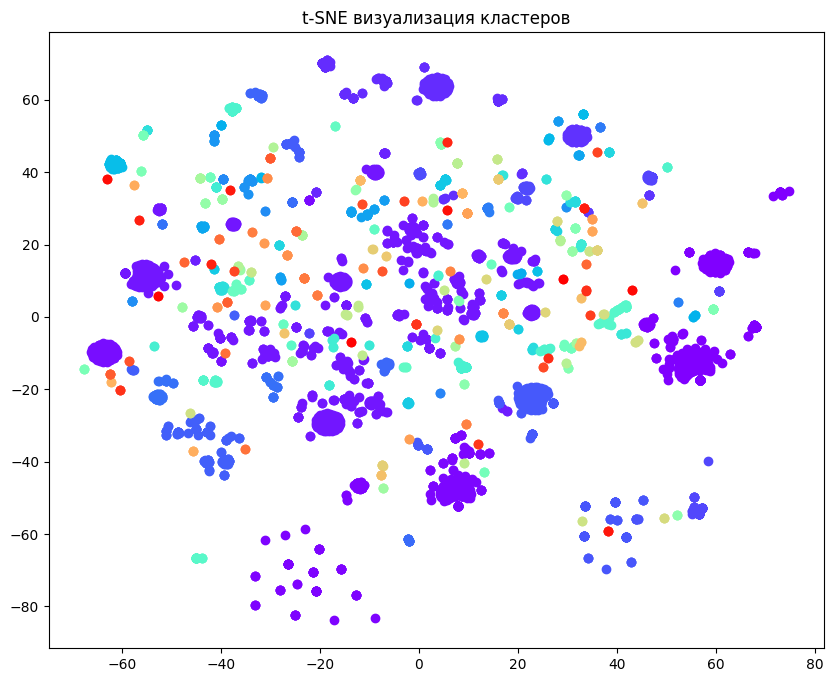

In [175]:
# Визуализация результатов (если применимо)
# Можно использовать t-SNE для снижения размерности, если X имеет больше двух измерений
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

best_n_clusters = max(clusters)

colors = plt.cm.rainbow(np.linspace(0, 1, best_n_clusters))
plt.figure(figsize=(10, 8))
for i in range(best_n_clusters):
    plt.scatter(X_tsne[clusters == i, 0], X_tsne[clusters == i, 1], color=colors[i], label=f'Cluster {i}')
plt.title('t-SNE визуализация кластеров')
plt.show()

In [177]:
# Подключение к базе данных для сохранения сниппета
db_path_norm = "../db//normalized_data.db"
conn_norm = sqlite3.connect(db_path_norm)

print(len(df))

mask = (df['cluster'] != -2) & (df['cluster'] != -3)
df.loc[mask, 'cluster'] = clusters

df.to_sql(name='clusters', con=conn_norm, if_exists='replace', index=False)

4335


4335